In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from python_helper_files.post_processing_multi import * # Import data post processing functions
from python_helper_files.plotting_helper import * # Import helper functions for plotting in ipynb
warnings.filterwarnings('ignore') # supress warnings for clenliness

# Loading data
Data is provided in a folder (or series of folders) and is loaded and processed with budget assignment by the ```load_multiple_files_budget``` function. This is wrapped in the load_max_cut_data. This takes a long time due to the large number of files that needs to be processed. If data were stored differently (i.e. in a database), this would be much faster. 

In [3]:
results = {qubit:load_max_cut_data(qubit) for qubit in [4,6,8,10]}
maxcut_df = pd.concat(results.values())


Qubit: 4, depth: 0, budget:0
Qubit: 4, depth: 0, budget:5
Qubit: 4, depth: 0, budget:6
Qubit: 4, depth: 0, budget:7
Qubit: 4, depth: 0, budget:8
Qubit: 4, depth: 0, budget:9
Qubit: 4, depth: 0, budget:10

Qubit: 6, depth: 0, budget:0
Qubit: 6, depth: 0, budget:5
Qubit: 6, depth: 0, budget:6
Qubit: 6, depth: 0, budget:7
Qubit: 6, depth: 0, budget:8
Qubit: 6, depth: 0, budget:9
Qubit: 6, depth: 0, budget:10

Qubit: 8, depth: 0, budget:0
Qubit: 8, depth: 0, budget:5
Qubit: 8, depth: 0, budget:6
Qubit: 8, depth: 0, budget:7
Qubit: 8, depth: 0, budget:8
Qubit: 8, depth: 0, budget:9
Qubit: 8, depth: 0, budget:10

Qubit: 10, depth: 0, budget:0
Qubit: 10, depth: 0, budget:5
Qubit: 10, depth: 0, budget:6
Qubit: 10, depth: 0, budget:7
Qubit: 10, depth: 0, budget:8
Qubit: 10, depth: 0, budget:9
Qubit: 10, depth: 0, budget:10


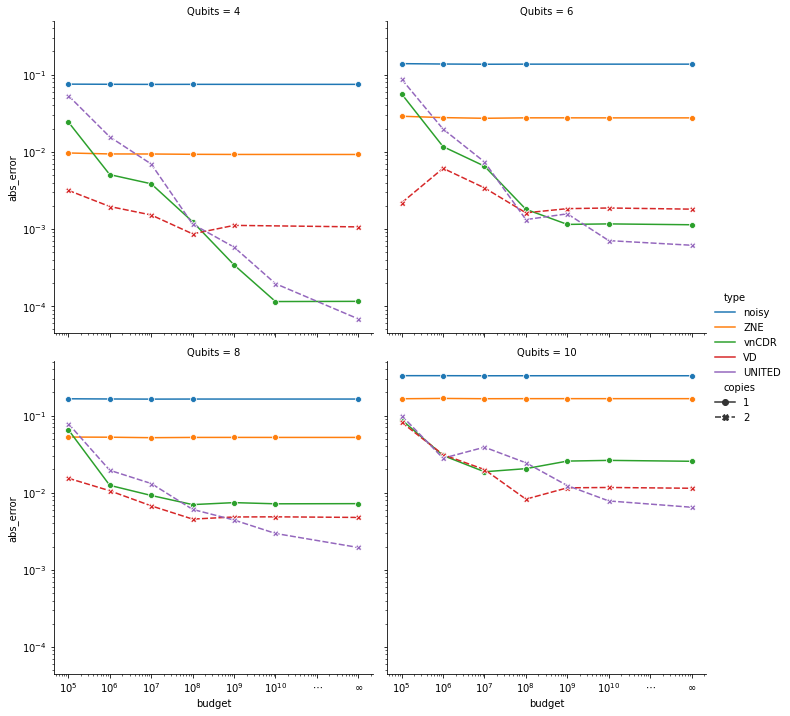

In [5]:
plot_over_budget(maxcut_df)

In [ ]:
maxcut_df.to_pickle('./MaxCut_runs/filtered_df.pkl')
maxcut_df.to_csv('./MaxCut_runs/filtered_df.csv')

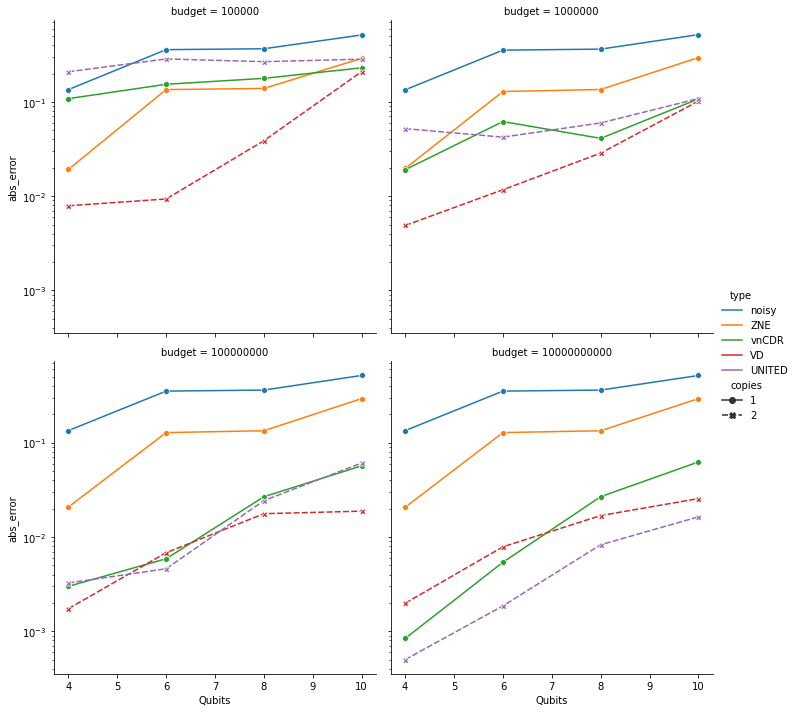

In [39]:
df = maxcut_df.query('budget>0&budget<10**11&(budget==10**5|budget==10**6|budget==10**8|budget==10**10)')
zero_copy_methods = df.query(
    'abs_error > 0  & copies == 1 & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type == "ZNE" | type == "vnCDR")'
)
noisy = df.query(
    'abs_error > 0  & copies == 1 & nlsp==1 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
few_copy_methods = df.query(
    'abs_error >  0  & nlsp==1 & copies==2 & description == "3nlsp_full" & res_type=="abs_error" & ( type=="VD")'
)
many_copy_methods = df.query(
    'abs_error > 0  &nlsp==1  & copies==2& description == "3nlsp_full" & res_type=="abs_error" & ( type=="UNITED")'
)
noisy["type"] = "noisy"
plot_df = pd.concat(
    [noisy, zero_copy_methods, few_copy_methods, many_copy_methods],
    axis=0,
    ignore_index=True,
)
fig = sns.relplot(
    data=plot_df.reset_index(),
    kind="line",
    x="Qubits",
    y="abs_error",
    hue="type",
    col="budget",
    col_wrap = 2,
    style="copies",
    estimator="max",
    markers=True,
    ci=None,
).set(yscale="log")

In [33]:
fig3 = plot_df.groupby(['type','Qubits','budget','copies']).aggregate('max').reset_index().drop(['copies','nlsp','depth'],axis=1).reset_index()


In [35]:
fig3.to_csv('./dataframes/fig3_MaxCut_MAX.csv')